In [1]:
import numpy as np
from hyperopt import hp, fmin, tpe, space_eval
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib import colors

In [2]:
def michaelismenten(x, vm, km):
    return (vm*x)/(km+x)

def reversible_michaelismenten(x, y, vm, keq, kmx, kmy):
    return (vm*(x - (y/keq)))/(x + kmx*(1+(y/kmy)))

def hilleqn(x, vm, n, km):
    return (vm*x**n)/(km**n + x**n)

def michaelismenten_substrateactivation(x, vm, km, a, ka):
    vm_eff = vm * (1+ (a*x)/(ka + x))
    return (vm_eff*x)/(km  + x)

def activation(x, k, theta, n):
    return (k*x**n)/(theta**n + x**n)
    
def repression(x, k, theta, n):
    return (k*theta**n)/(theta**n + x**n)
    
def loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2):
    loss = alpha1*j1 + alpha2*j2
    return j1, j2, loss

In [3]:
def glucaric_acid(t, y, ydot, params):

    lam = 2.7778E-05
    v_pts = 0.1656
    vm_pgi = 0.8751
    keq_pgi = 0.3
    km_pgi_g6p = 0.28
    km_pgi_f6p = 0.147
    vm_zwf = 0.0853
    km_zwf_g6p = 0.1
    vm_pfk = 2.615
    km_pfk_f6p = 0.16
    n_pfk = 3
    vm_ino1 = 0.2616
    km_ino1_g6p = 1.18
    vm_t_mi = 0.045
    km_t_mi = 15
    vm_miox = 0.2201
    km_miox_mi = 24.7
    a_miox = 5.4222
    ka_miox_mi = 20


    g6p, f6p, mi, ino1, miox, j1, j2 = y

    A, W = params 

    n_ino1, theta_ino1, k_ino1 = W[0]
    n_miox, theta_miox, k_miox = W[1]

    v_pgi = reversible_michaelismenten(g6p, f6p, vm_pgi, keq_pgi, km_pgi_g6p, km_pgi_f6p)
    v_zwf = michaelismenten(g6p, vm_zwf, km_zwf_g6p)
    v_pfk = hilleqn(f6p, vm_pfk, n_pfk, km_pfk_f6p)
    v_ino1 = ino1 * michaelismenten(g6p, vm_ino1, km_ino1_g6p)
    v_tm = michaelismenten(mi, vm_t_mi, km_t_mi)
    v_miox = miox * michaelismenten_substrateactivation(mi, vm_miox, km_miox_mi, a_miox, ka_miox_mi)

    u_ino1_mi = np.sum(A[0]*np.array([activation(mi, k_ino1, theta_ino1, n_ino1), repression(mi, k_ino1, theta_ino1, n_ino1), k_ino1]))
    u_miox_mi = np.sum(A[1]*np.array([activation(mi, k_miox, theta_miox, n_miox), repression(mi, k_miox, theta_miox, n_miox), k_miox]))

    ydot[0] = v_pts - v_zwf - v_pgi - lam*g6p
    ydot[1] = v_pgi + 0.5*v_zwf - v_pfk - lam*f6p
    ydot[2] = v_ino1 - v_tm - v_miox - lam*mi
    ydot[3] = u_ino1_mi  - lam*ino1
    ydot[4] = u_miox_mi - lam*miox
    ydot[5] = (v_pts - v_miox)**2
    ydot[6] = u_ino1_mi + u_miox_mi

In [4]:
def name_converter(A):
    if A == '((0, 1, 0), (1, 0, 0))':
        return 'Dual Control'

    elif A == '((0, 0, 1), (0, 0, 1))':
        return 'No Control'

    elif A == '((0, 0, 1), (1, 0, 0))':
        return 'Downstream Activation'

    elif A == '((0, 1, 0), (0, 0, 1))':
        return 'Upstream Repression'
    else: return 'Invalid Circuit'

In [ ]:
#Multiarch example
circuit_name = 'multiarch'
space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 1E-7, 10), hp.uniform('k1_da', 1E-7, 5)], [2., hp.uniform('theta2_da', 1E-7, 10), hp.uniform('k2_da', 1E-7, 5)]]),
     ([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 1E-7, 10), hp.uniform('k1_ur', 1E-7, 5)], [2., hp.uniform('theta2_ur', 1E-7, 10), hp.uniform('k2_ur', 1E-7, 5)]]),
     ([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 1E-7, 10), hp.uniform('k1_nc', 1E-7, 5)], [2., hp.uniform('theta2_nc', 1E-7, 10), hp.uniform('k2_nc', 1E-7, 5)]]),
     ([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 1E-7, 10), hp.uniform('k1_dc', 1E-7, 5)], [2., hp.uniform('theta2_dc', 1E-7, 10), hp.uniform('k2_dc', 1E-7, 5)]])])

losses = []
params = []
circuits = []
sols = []
def objective(args):
    architecture, param_values = args
    #Integration conditions
    t = np.linspace(0, 5E5, 200) 
    y0 = np.array([0.281, 0.0605, 0., 0., 0. , 0., 0.]) #g6p, f6p, mi, ino1, miox

    extra_options = {'old_api': False, 'user_data': [architecture, param_values], 'rtol':1E-4}
    ode_solver = ode('cvode', glucaric_acid, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-3)
    losses.append(loss)
    params.append(param_values)
    circuits.append(architecture)
    return loss
    
best = fmin(objective, space, algo=tpe.suggest, max_evals=2000)

landscape = pd.DataFrame({'circuit':circuits, 'loss': losses, 'k1': [params[i][0][2] for i in range(len(params))], 'k2': [params[i][1][2] for i in range(len(params))], 'theta1': [params[i][0][1] for i in range(len(params))], 'theta2': [params[i][1][1] for i in range(len(params))]})
landscape['circuit'] = [str(landscape.circuit[i]) for i in range(len(landscape))]
landscape['Circuit'] = [name_converter(landscape.circuit[i]) for i in range(len(landscape))]
landscape.to_csv(circuit_name+'_2000iters.csv')
space_eval(space, best)

In [5]:
#Multiarch example
circuit_name = 'dual_control'
space = hp.choice('architecture', 
    [#([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 1E-7, 10), hp.uniform('k1_da', 1E-7, 5)], [2., hp.uniform('theta2_da', 1E-7, 10), hp.uniform('k2_da', 1E-7, 5)]]),
     #([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 1E-7, 10), hp.uniform('k1_ur', 1E-7, 5)], [2., hp.uniform('theta2_ur', 1E-7, 10), hp.uniform('k2_ur', 1E-7, 5)]]),
     #([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 1E-7, 10), hp.uniform('k1_nc', 1E-7, 5)], [2., hp.uniform('theta2_nc', 1E-7, 10), hp.uniform('k2_nc', 1E-7, 5)]]),
     ([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 1E-7, 10), hp.uniform('k1_dc', 1E-7, 5)], [2., hp.uniform('theta2_dc', 1E-7, 10), hp.uniform('k2_dc', 1E-7, 5)]])])

losses = []
params = []
circuits = []
sols = []
def objective(args):
    architecture, param_values = args
    #Integration conditions
    t = np.linspace(0, 5E5, 200) 
    y0 = np.array([0.281, 0.0605, 0., 0., 0. , 0., 0.]) #g6p, f6p, mi, ino1, miox

    extra_options = {'old_api': False, 'user_data': [architecture, param_values], 'rtol':1E-4}
    ode_solver = ode('cvode', glucaric_acid, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-3)
    losses.append(loss)
    params.append(param_values)
    circuits.append(architecture)
    return loss
    
best = fmin(objective, space, algo=tpe.suggest, max_evals=2000)

landscape = pd.DataFrame({'circuit':circuits, 'loss': losses, 'k1': [params[i][0][2] for i in range(len(params))], 'k2': [params[i][1][2] for i in range(len(params))], 'theta1': [params[i][0][1] for i in range(len(params))], 'theta2': [params[i][1][1] for i in range(len(params))]})
landscape['circuit'] = [str(landscape.circuit[i]) for i in range(len(landscape))]
landscape['Circuit'] = [name_converter(landscape.circuit[i]) for i in range(len(landscape))]
landscape.to_csv(circuit_name+'_2000iters.csv')
space_eval(space, best)

100%|██████████| 2000/2000 [01:02<00:00, 32.02trial/s, best loss: 0.06737966147267688]


(((0, 1, 0), (1, 0, 0)),
 ((2.0, 1.7045475957953662, 0.10964053215370727),
  (2.0, 8.390182793426012, 6.904693261002709e-06)))

In [10]:
#Multiarch example
circuit_name = 'upstream_repression'
space = hp.choice('architecture', 
    [#([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 1E-7, 10), hp.uniform('k1_da', 1E-7, 5)], [2., hp.uniform('theta2_da', 1E-7, 10), hp.uniform('k2_da', 1E-7, 5)]])
     ([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 1E-7, 10), hp.uniform('k1_ur', 1E-7, 5)], [2., hp.uniform('theta2_ur', 1E-7, 10), hp.uniform('k2_ur', 1E-7, 5)]])
     #([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 1E-7, 10), hp.uniform('k1_nc', 1E-7, 5)], [2., hp.uniform('theta2_nc', 1E-7, 10), hp.uniform('k2_nc', 1E-7, 5)]])
     #([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 1E-7, 10), hp.uniform('k1_dc', 1E-7, 5)], [2., hp.uniform('theta2_dc', 1E-7, 10), hp.uniform('k2_dc', 1E-7, 5)]])
     ])
     

losses = []
params = []
circuits = []
sols = []
def objective(args):
    architecture, param_values = args
    #Integration conditions
    t = np.linspace(0, 5E5, 200) 
    y0 = np.array([0.281, 0.0605, 0., 0., 0. , 0., 0.]) #g6p, f6p, mi, ino1, miox

    extra_options = {'old_api': False, 'user_data': [architecture, param_values], 'rtol':1E-4}
    ode_solver = ode('cvode', glucaric_acid, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-3)
    losses.append(loss)
    params.append(param_values)
    circuits.append(architecture)
    return loss
    
best = fmin(objective, space, algo=tpe.suggest, max_evals=2000)

landscape = pd.DataFrame({'circuit':circuits, 'loss': losses, 'k1': [params[i][0][2] for i in range(len(params))], 'k2': [params[i][1][2] for i in range(len(params))], 'theta1': [params[i][0][1] for i in range(len(params))], 'theta2': [params[i][1][1] for i in range(len(params))]})
landscape['circuit'] = [str(landscape.circuit[i]) for i in range(len(landscape))]
landscape['Circuit'] = [name_converter(landscape.circuit[i]) for i in range(len(landscape))]
landscape.to_csv(circuit_name+'_2000iters.csv')
space_eval(space, best)

100%|██████████| 2000/2000 [01:03<00:00, 31.69trial/s, best loss: 0.07104343419495682]


(((0, 1, 0), (0, 0, 1)),
 ((2.0, 0.5405800523744403, 2.231836147377414),
  (2.0, 0.30196960409832196, 2.907722463580244e-06)))

In [12]:
#Multiarch example
circuit_name = 'downstream_activation'
space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 1E-7, 10), hp.uniform('k1_da', 1E-7, 5)], [2., hp.uniform('theta2_da', 1E-7, 10), hp.uniform('k2_da', 1E-7, 5)]])
     #([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 1E-7, 10), hp.uniform('k1_ur', 1E-7, 5)], [2., hp.uniform('theta2_ur', 1E-7, 10), hp.uniform('k2_ur', 1E-7, 5)]])
     #([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 1E-7, 10), hp.uniform('k1_nc', 1E-7, 5)], [2., hp.uniform('theta2_nc', 1E-7, 10), hp.uniform('k2_nc', 1E-7, 5)]])
     #([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 1E-7, 10), hp.uniform('k1_dc', 1E-7, 5)], [2., hp.uniform('theta2_dc', 1E-7, 10), hp.uniform('k2_dc', 1E-7, 5)]])
     ])
     

losses = []
params = []
circuits = []
sols = []
def objective(args):
    architecture, param_values = args
    #Integration conditions
    t = np.linspace(0, 5E5, 200) 
    y0 = np.array([0.281, 0.0605, 0., 0., 0. , 0., 0.]) #g6p, f6p, mi, ino1, miox

    extra_options = {'old_api': False, 'user_data': [architecture, param_values], 'rtol':1E-4}
    ode_solver = ode('cvode', glucaric_acid, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-3)
    losses.append(loss)
    params.append(param_values)
    circuits.append(architecture)
    return loss
    
best = fmin(objective, space, algo=tpe.suggest, max_evals=2000)

landscape = pd.DataFrame({'circuit':circuits, 'loss': losses, 'k1': [params[i][0][2] for i in range(len(params))], 'k2': [params[i][1][2] for i in range(len(params))], 'theta1': [params[i][0][1] for i in range(len(params))], 'theta2': [params[i][1][1] for i in range(len(params))]})
landscape['circuit'] = [str(landscape.circuit[i]) for i in range(len(landscape))]
landscape['Circuit'] = [name_converter(landscape.circuit[i]) for i in range(len(landscape))]
landscape.to_csv(circuit_name+'_2000iters.csv')
space_eval(space, best)

100%|██████████| 2000/2000 [01:04<00:00, 31.23trial/s, best loss: 0.373804954622279]


(((0, 0, 1), (1, 0, 0)),
 ((2.0, 5.117871627302142, 6.417429827862528e-06),
  (2.0, 2.9102507582289996, 0.8714559818228125)))

In [13]:
#Multiarch example
circuit_name = 'open_loop'
space = hp.choice('architecture', 
    [#([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 1E-7, 10), hp.uniform('k1_da', 1E-7, 5)], [2., hp.uniform('theta2_da', 1E-7, 10), hp.uniform('k2_da', 1E-7, 5)]])
     #([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 1E-7, 10), hp.uniform('k1_ur', 1E-7, 5)], [2., hp.uniform('theta2_ur', 1E-7, 10), hp.uniform('k2_ur', 1E-7, 5)]])
     ([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 1E-7, 10), hp.uniform('k1_nc', 1E-7, 5)], [2., hp.uniform('theta2_nc', 1E-7, 10), hp.uniform('k2_nc', 1E-7, 5)]])
     #([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 1E-7, 10), hp.uniform('k1_dc', 1E-7, 5)], [2., hp.uniform('theta2_dc', 1E-7, 10), hp.uniform('k2_dc', 1E-7, 5)]])
     ])
     

losses = []
params = []
circuits = []
sols = []
def objective(args):
    architecture, param_values = args
    #Integration conditions
    t = np.linspace(0, 5E5, 200) 
    y0 = np.array([0.281, 0.0605, 0., 0., 0. , 0., 0.]) #g6p, f6p, mi, ino1, miox

    extra_options = {'old_api': False, 'user_data': [architecture, param_values], 'rtol':1E-4}
    ode_solver = ode('cvode', glucaric_acid, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-3)
    losses.append(loss)
    params.append(param_values)
    circuits.append(architecture)
    return loss
    
best = fmin(objective, space, algo=tpe.suggest, max_evals=2000)

landscape = pd.DataFrame({'circuit':circuits, 'loss': losses, 'k1': [params[i][0][2] for i in range(len(params))], 'k2': [params[i][1][2] for i in range(len(params))], 'theta1': [params[i][0][1] for i in range(len(params))], 'theta2': [params[i][1][1] for i in range(len(params))]})
landscape['circuit'] = [str(landscape.circuit[i]) for i in range(len(landscape))]
landscape['Circuit'] = [name_converter(landscape.circuit[i]) for i in range(len(landscape))]
landscape.to_csv(circuit_name+'_2000iters.csv')
space_eval(space, best)

100%|██████████| 2000/2000 [01:01<00:00, 32.42trial/s, best loss: 0.6644345538766575]


(((0, 0, 1), (0, 0, 1)),
 ((2.0, 7.6025800352792885, 0.0002716258769185167),
  (2.0, 1.2681953752466693, 0.00019620147581395552)))

In [65]:
def compute_best_loss(landscape):
    best_loss = 1E10
    best_losses = []
    for i in range(len(landscape)):
        if landscape.loss[i] < best_loss:
            best_loss = landscape.loss[i]
        best_losses.append(best_loss)
    return best_losses

In [26]:
#Check for number of iterations to convergence
da_landscape = pd.read_csv('downstream_activation_2000iters.csv')
dc_landscape = pd.read_csv('dual_control_2000iters.csv')
nc_landscape = pd.read_csv('open_loop_2000iters.csv')
ur_landscape = pd.read_csv('upstream_repression_2000iters.csv')

da_landscape['best_loss'] = compute_best_loss(da_landscape)
dc_landscape['best_loss'] = compute_best_loss(dc_landscape)
nc_landscape['best_loss'] = compute_best_loss(nc_landscape)
ur_landscape['best_loss'] = compute_best_loss(ur_landscape)

da_landscape['iters'] = range(2000)
dc_landscape['iters'] = range(2000)
nc_landscape['iters'] = range(2000)
ur_landscape['iters'] = range(2000)
landscape = pd.concat([da_landscape, dc_landscape, nc_landscape, ur_landscape]).reset_index(drop=True)

In [191]:
orders = ['No Control', 'Upstream Repression', 'Downstream Activation', 'Dual Control', 'Multiarchitecture']
palette = {'Multiarchitecture': sns.color_palette()[4], 'No Control': sns.color_palette()[3], 'Upstream Repression': sns.color_palette()[1], 'Downstream Activation': sns.color_palette()[2], 'Dual Control': sns.color_palette()[0], 'Initial':'black'}


Text(0.5, 1.0, 'Loss Trajectory over a Single Iteration, Max_Iters = 2000')

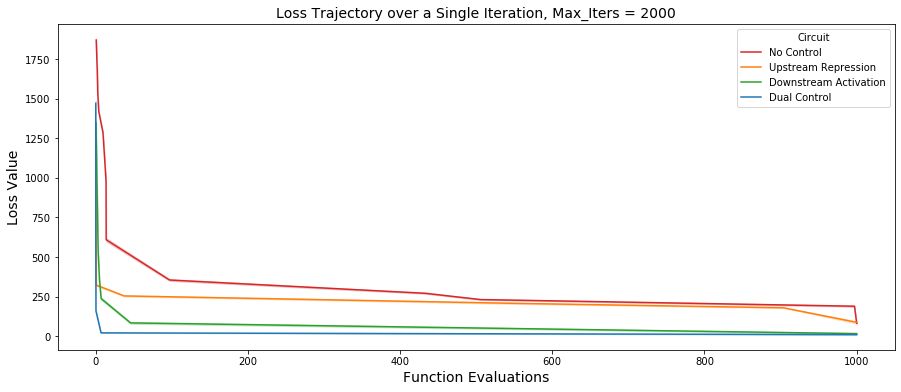

In [36]:
fig, axs = plt.subplots(1, 1, figsize=(15, 6))
endpoint = 'Loss Trajectory over a Single Iteration, Max_Iters = 2000'
ax = axs
sns.lineplot(data=landscape, x='best_loss', y='iters', hue='Circuit', hue_order=orders, palette=palette)
ax.set_xlabel('Function Evaluations', fontsize=14)
ax.set_ylabel('Loss Value', fontsize=14)
ax.set_title(endpoint, fontsize=14)
#ax.set_yscale('log')
#fig.savefig('loss_over_iteration.png')

In [66]:
#Run with 500 iterations 10 times each

#Multiarch example
circuit_name = 'upstream_repression'
space = hp.choice('architecture', 
    [#([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 1E-7, 10), hp.uniform('k1_da', 1E-7, 5)], [2., hp.uniform('theta2_da', 1E-7, 10), hp.uniform('k2_da', 1E-7, 5)]])
     ([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 1E-7, 10), hp.uniform('k1_ur', 1E-7, 5)], [2., hp.uniform('theta2_ur', 1E-7, 10), hp.uniform('k2_ur', 1E-7, 5)]])
     #([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 1E-7, 10), hp.uniform('k1_nc', 1E-7, 5)], [2., hp.uniform('theta2_nc', 1E-7, 10), hp.uniform('k2_nc', 1E-7, 5)]])
     #([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 1E-7, 10), hp.uniform('k1_dc', 1E-7, 5)], [2., hp.uniform('theta2_dc', 1E-7, 10), hp.uniform('k2_dc', 1E-7, 5)]])
     ])
     
    
results = pd.DataFrame(columns=['circuit', 'loss', 'k1', 'k2','theta1', 'theta2'])
max_iters = 500
num_tries = 15
for n in range(num_tries):
    losses = []
    params = []
    circuits = []
    sols = []
    def objective(args):
        architecture, param_values = args
        #Integration conditions
        t = np.linspace(0, 5E5, 200) 
        y0 = np.array([0.281, 0.0605, 0., 0., 0. , 0., 0.]) #g6p, f6p, mi, ino1, miox

        extra_options = {'old_api': False, 'user_data': [architecture, param_values], 'rtol':1E-4}
        ode_solver = ode('cvode', glucaric_acid, **extra_options)
        solution = ode_solver.solve(t, y0)
        j1, j2 = solution.values.y[-1, -2:]
        j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-3)
        losses.append(loss)
        params.append(param_values)
        circuits.append(architecture)
        return loss
    
    best = fmin(objective, space, algo=tpe.suggest, max_evals=max_iters)
    attempt_res = pd.DataFrame({'circuit':circuits, 'loss': losses, 'k1': [params[i][0][2] for i in range(len(params))], 'k2': [params[i][1][2] for i in range(len(params))], 'theta1': [params[i][0][1] for i in range(len(params))], 'theta2': [params[i][1][1] for i in range(len(params))]})
    attempt_res['attempt'] = n
    attempt_res['best_loss'] = compute_best_loss(attempt_res)
    if losses[-1] == 0.0:
        break
    results = pd.concat([results,attempt_res])

results.to_csv(circuit_name + '_10iterations_best.csv')

100%|██████████| 500/500 [00:12<00:00, 39.42trial/s, best loss: 1.4199637731284118]


In [67]:
#Run with 500 iterations 10 times each

#Multiarch example
circuit_name = 'no_control'
space = hp.choice('architecture', 
    [#([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 1E-7, 10), hp.uniform('k1_da', 1E-7, 5)], [2., hp.uniform('theta2_da', 1E-7, 10), hp.uniform('k2_da', 1E-7, 5)]])
     #([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 1E-7, 10), hp.uniform('k1_ur', 1E-7, 5)], [2., hp.uniform('theta2_ur', 1E-7, 10), hp.uniform('k2_ur', 1E-7, 5)]])
     ([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 1E-7, 10), hp.uniform('k1_nc', 1E-7, 5)], [2., hp.uniform('theta2_nc', 1E-7, 10), hp.uniform('k2_nc', 1E-7, 5)]])
     #([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 1E-7, 10), hp.uniform('k1_dc', 1E-7, 5)], [2., hp.uniform('theta2_dc', 1E-7, 10), hp.uniform('k2_dc', 1E-7, 5)]])
     ])
     
    
results = pd.DataFrame(columns=['circuit', 'loss', 'k1', 'k2','theta1', 'theta2'])
max_iters = 500
num_tries = 11
for n in range(num_tries):
    losses = []
    params = []
    circuits = []
    sols = []
    def objective(args):
        architecture, param_values = args
        #Integration conditions
        t = np.linspace(0, 5E5, 200) 
        y0 = np.array([0.281, 0.0605, 0., 0., 0. , 0., 0.]) #g6p, f6p, mi, ino1, miox

        extra_options = {'old_api': False, 'user_data': [architecture, param_values], 'rtol':1E-4}
        ode_solver = ode('cvode', glucaric_acid, **extra_options)
        solution = ode_solver.solve(t, y0)
        j1, j2 = solution.values.y[-1, -2:]
        j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-3)
        losses.append(loss)
        params.append(param_values)
        circuits.append(architecture)
        return loss

    best = fmin(objective, space, algo=tpe.suggest, max_evals=max_iters)
    attempt_res = pd.DataFrame({'circuit':circuits, 'loss': losses, 'k1': [params[i][0][2] for i in range(len(params))], 'k2': [params[i][1][2] for i in range(len(params))], 'theta1': [params[i][0][1] for i in range(len(params))], 'theta2': [params[i][1][1] for i in range(len(params))]})
    attempt_res['attempt'] = n
    attempt_res['best_loss'] = compute_best_loss(attempt_res)
    results = pd.concat([results,attempt_res])
    if losses[-1] == 0.0:
        break
results.to_csv(circuit_name + '_10iterations_best.csv')

 18%|█▊        | 92/500 [00:02<00:10, 40.48trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1960, mxstep steps taken before reaching tout.



100%|██████████| 500/500 [00:12<00:00, 41.27trial/s, best loss: 20.325568131799155]


In [68]:
#Run with 500 iterations 10 times each

#Multiarch example
circuit_name = 'downstream_activation'
space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 1E-7, 10), hp.uniform('k1_da', 1E-7, 5)], [2., hp.uniform('theta2_da', 1E-7, 10), hp.uniform('k2_da', 1E-7, 5)]])
     #([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 1E-7, 10), hp.uniform('k1_ur', 1E-7, 5)], [2., hp.uniform('theta2_ur', 1E-7, 10), hp.uniform('k2_ur', 1E-7, 5)]])
     #([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 1E-7, 10), hp.uniform('k1_nc', 1E-7, 5)], [2., hp.uniform('theta2_nc', 1E-7, 10), hp.uniform('k2_nc', 1E-7, 5)]])
     #([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 1E-7, 10), hp.uniform('k1_dc', 1E-7, 5)], [2., hp.uniform('theta2_dc', 1E-7, 10), hp.uniform('k2_dc', 1E-7, 5)]])
     ])
     
    
results = pd.DataFrame(columns=['circuit', 'loss', 'k1', 'k2','theta1', 'theta2'])
max_iters = 500
num_tries = 15
for n in range(num_tries):
    losses = []
    params = []
    circuits = []
    sols = []
    def objective(args):
        architecture, param_values = args
        #Integration conditions
        t = np.linspace(0, 5E5, 200) 
        y0 = np.array([0.281, 0.0605, 0., 0., 0. , 0., 0.]) #g6p, f6p, mi, ino1, miox

        extra_options = {'old_api': False, 'user_data': [architecture, param_values], 'rtol':1E-4}
        ode_solver = ode('cvode', glucaric_acid, **extra_options)
        solution = ode_solver.solve(t, y0)
        j1, j2 = solution.values.y[-1, -2:]
        j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-3)
        losses.append(loss)
        params.append(param_values)
        circuits.append(architecture)
        return loss

    best = fmin(objective, space, algo=tpe.suggest, max_evals=max_iters)
    attempt_res = pd.DataFrame({'circuit':circuits, 'loss': losses, 'k1': [params[i][0][2] for i in range(len(params))], 'k2': [params[i][1][2] for i in range(len(params))], 'theta1': [params[i][0][1] for i in range(len(params))], 'theta2': [params[i][1][1] for i in range(len(params))]})
    attempt_res['attempt'] = n
    attempt_res['best_loss'] = compute_best_loss(attempt_res)
    if losses[-1] == 0.0:
        break
    results = pd.concat([results,attempt_res])

results.to_csv(circuit_name + '_10iterations_best.csv')

 38%|███▊      | 189/500 [00:04<00:07, 39.03trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1754.03, mxstep steps taken before reaching tout.



 10%|▉         | 49/500 [00:01<00:11, 40.30trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1453.69, mxstep steps taken before reaching tout.



 29%|██▊       | 143/500 [00:03<00:09, 37.97trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1601.03, mxstep steps taken before reaching tout.



100%|██████████| 500/500 [00:13<00:00, 37.13trial/s, best loss: 1.161868135144332]


In [69]:
#Run with 500 iterations 10 times each

#Multiarch example
circuit_name = 'dual_control'
space = hp.choice('architecture', 
    [#([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 1E-7, 10), hp.uniform('k1_da', 1E-7, 5)], [2., hp.uniform('theta2_da', 1E-7, 10), hp.uniform('k2_da', 1E-7, 5)]])
     #([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 1E-7, 10), hp.uniform('k1_ur', 1E-7, 5)], [2., hp.uniform('theta2_ur', 1E-7, 10), hp.uniform('k2_ur', 1E-7, 5)]])
     #([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 1E-7, 10), hp.uniform('k1_nc', 1E-7, 5)], [2., hp.uniform('theta2_nc', 1E-7, 10), hp.uniform('k2_nc', 1E-7, 5)]])
     ([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 1E-7, 10), hp.uniform('k1_dc', 1E-7, 5)], [2., hp.uniform('theta2_dc', 1E-7, 10), hp.uniform('k2_dc', 1E-7, 5)]])
     ])
     
    
results = pd.DataFrame(columns=['circuit', 'loss', 'k1', 'k2','theta1', 'theta2'])
max_iters = 500
num_tries = 12
for n in range(num_tries):
    losses = []
    params = []
    circuits = []
    sols = []
    def objective(args):
        architecture, param_values = args
        #Integration conditions
        t = np.linspace(0, 5E5, 200) 
        y0 = np.array([0.281, 0.0605, 0., 0., 0. , 0., 0.]) #g6p, f6p, mi, ino1, miox

        extra_options = {'old_api': False, 'user_data': [architecture, param_values], 'rtol':1E-4}
        ode_solver = ode('cvode', glucaric_acid, **extra_options)
        solution = ode_solver.solve(t, y0)
        j1, j2 = solution.values.y[-1, -2:]
        j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-3)
        losses.append(loss)
        params.append(param_values)
        circuits.append(architecture)
        return loss

    best = fmin(objective, space, algo=tpe.suggest, max_evals=max_iters)
    attempt_res = pd.DataFrame({'circuit':circuits, 'loss': losses, 'k1': [params[i][0][2] for i in range(len(params))], 'k2': [params[i][1][2] for i in range(len(params))], 'theta1': [params[i][0][1] for i in range(len(params))], 'theta2': [params[i][1][1] for i in range(len(params))]})
    attempt_res['attempt'] = n
    attempt_res['best_loss'] = compute_best_loss(attempt_res)
    if losses[-1] == 0.0:
        break
    results = pd.concat([results,attempt_res])

results.to_csv(circuit_name + '_10iterations_best.csv')

  3%|▎         | 15/500 [00:00<00:11, 43.52trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 2312.94, mxstep steps taken before reaching tout.



 49%|████▉     | 245/500 [00:06<00:07, 36.21trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1504.67, mxstep steps taken before reaching tout.



 71%|███████   | 355/500 [00:09<00:04, 36.01trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1455.17, mxstep steps taken before reaching tout.



100%|██████████| 500/500 [00:12<00:00, 39.72trial/s, best loss: 0.1401094552958524]


In [53]:
#Rerun to get rid of errors
#Multiarch example
circuit_name = 'upstream_repression'
space = hp.choice('architecture', 
    [#([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 1E-7, 10), hp.uniform('k1_da', 1E-7, 5)], [2., hp.uniform('theta2_da', 1E-7, 10), hp.uniform('k2_da', 1E-7, 5)]])
     ([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 1E-7, 10), hp.uniform('k1_ur', 1E-7, 5)], [2., hp.uniform('theta2_ur', 1E-7, 10), hp.uniform('k2_ur', 1E-7, 5)]])
     #([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 1E-7, 10), hp.uniform('k1_nc', 1E-7, 5)], [2., hp.uniform('theta2_nc', 1E-7, 10), hp.uniform('k2_nc', 1E-7, 5)]])
     #([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 1E-7, 10), hp.uniform('k1_dc', 1E-7, 5)], [2., hp.uniform('theta2_dc', 1E-7, 10), hp.uniform('k2_dc', 1E-7, 5)]])
     ])
     
    
results = pd.DataFrame(columns=['circuit', 'loss', 'k1', 'k2','theta1', 'theta2'])
max_iters = 500
num_tries = 2
for n in range(num_tries):
    losses = []
    params = []
    circuits = []
    sols = []
    def objective(args):
        architecture, param_values = args
        #Integration conditions
        t = np.linspace(0, 5E5, 200) 
        y0 = np.array([0.281, 0.0605, 0., 0., 0. , 0., 0.]) #g6p, f6p, mi, ino1, miox

        extra_options = {'old_api': False, 'user_data': [architecture, param_values], 'rtol':1E-4}
        ode_solver = ode('cvode', glucaric_acid, **extra_options)
        solution = ode_solver.solve(t, y0)
        j1, j2 = solution.values.y[-1, -2:]
        j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-3)
        losses.append(loss)
        params.append(param_values)
        circuits.append(architecture)
        return loss

    best = fmin(objective, space, algo=tpe.suggest, max_evals=max_iters)
    attempt_res = pd.DataFrame({'circuit':circuits, 'loss': losses, 'k1': [params[i][0][2] for i in range(len(params))], 'k2': [params[i][1][2] for i in range(len(params))], 'theta1': [params[i][0][1] for i in range(len(params))], 'theta2': [params[i][1][1] for i in range(len(params))]})
    attempt_res['attempt'] = n
    attempt_res['best_loss'] = compute_best_loss(attempt_res)
    results = pd.concat([results,attempt_res])

100%|██████████| 500/500 [00:12<00:00, 38.78trial/s, best loss: 2.132663070295129]


In [54]:
ur_multtries = pd.concat([ur_multtries, results])
ur_multtries.to_csv('upstream_repression_10iterations_best.csv')

In [70]:
ur_multtries = pd.read_csv('upstream_repression_10iterations_best.csv')
da_multtries = pd.read_csv('downstream_activation_10iterations_best.csv')
dc_multtries = pd.read_csv('dual_control_10iterations_best.csv')
nc_multtries = pd.read_csv('no_control_10iterations_best.csv')


In [81]:
dc_multtries = dc_multtries.loc[dc_multtries.attempt.isin([0, 1, 3, 4, 5, 6, 7, 8, 10, 11])]
nc_multtries = nc_multtries.loc[nc_multtries.attempt.isin([0, 1, 2, 3, 4, 5, 6, 7, 8, 10])]
da_multtries = da_multtries.loc[da_multtries.attempt.isin([0, 1, 2, 3, 4, 6, 7, 8, 9, 10])]

In [96]:
combined_multtries = pd.concat([dc_multtries, da_multtries, nc_multtries, ur_multtries]).reset_index(drop=True)
combined_multtries['circuit'] = [str(combined_multtries.circuit[i]) for i in range(len(combined_multtries))]
combined_multtries['Circuit'] = [name_converter(combined_multtries.circuit[i]) for i in range(len(combined_multtries))]

In [113]:
combined_multtries

,Unnamed: 0,circuit,loss,k1,k2,theta1,theta2,attempt,best_loss,iters
0,0,"((0, 1, 0), (1, 0, 0))",6.324288e+05,0.768875,3.337248,1.178872,4.954224,0.0,632428.839602,0
1,1,"((0, 1, 0), (1, 0, 0))",2.351834e+07,1.481776,1.791935,9.337815,2.862204,0.0,632428.839602,1
2,2,"((0, 1, 0), (1, 0, 0))",1.617472e+07,1.201117,4.738110,7.130771,3.976084,0.0,632428.839602,2
3,3,"((0, 1, 0), (1, 0, 0))",8.953301e+04,0.081843,1.645388,7.670620,4.374687,0.0,89533.014710,3
4,4,"((0, 1, 0), (1, 0, 0))",7.591382e+07,3.760970,2.294452,8.367621,7.521604,0.0,89533.014710,4
...,...,...,...,...,...,...,...,...,...,...
5995,495,"((0, 1, 0), (1, 0, 0))",2.256937e+03,0.183028,0.077313,0.983999,8.436694,11.0,0.140109,495
5996,496,"((0, 1, 0), (1, 0, 0))",3.013078e+04,1.898987,0.203546,0.656328,8.906582,11.0,0.140109,496
5997,497,"((0, 1, 0), (1, 0, 0))",1.619673e+00,0.725938,0.427664,0.009993,7.361287,11.0,0.140109,497
5998,498,"((0, 1, 0), (1, 0, 0))",6.657281e+03,0.891306,0.323013,0.448163,9.263186,11.0,0.140109,498


In [117]:
combined_multtries = pd.DataFrame()
for attempt in dc_multtries.attempt.unique():
    df = dc_multtries.loc[dc_multtries.attempt == attempt].reset_index(drop=True)
    df['iters'] = range(500)
    combined_multtries = pd.concat([combined_multtries, df])

for attempt in nc_multtries.attempt.unique():
    df = nc_multtries.loc[nc_multtries.attempt == attempt].reset_index(drop=True)
    df['iters'] = range(500)
    combined_multtries = pd.concat([combined_multtries, df])

for attempt in ur_multtries.attempt.unique():
    df = ur_multtries.loc[ur_multtries.attempt == attempt].reset_index(drop=True)
    df['iters'] = range(500)
    combined_multtries = pd.concat([combined_multtries, df])

for attempt in da_multtries.attempt.unique():
    df = da_multtries.loc[da_multtries.attempt == attempt].reset_index(drop=True)
    df['iters'] = range(500)
    combined_multtries = pd.concat([combined_multtries, df])


combined_multtries = combined_multtries.reset_index(drop=True)
combined_multtries['circuit'] = [str(combined_multtries.circuit[i]) for i in range(len(combined_multtries))]
combined_multtries['Circuit'] = [name_converter(combined_multtries.circuit[i]) for i in range(len(combined_multtries))]

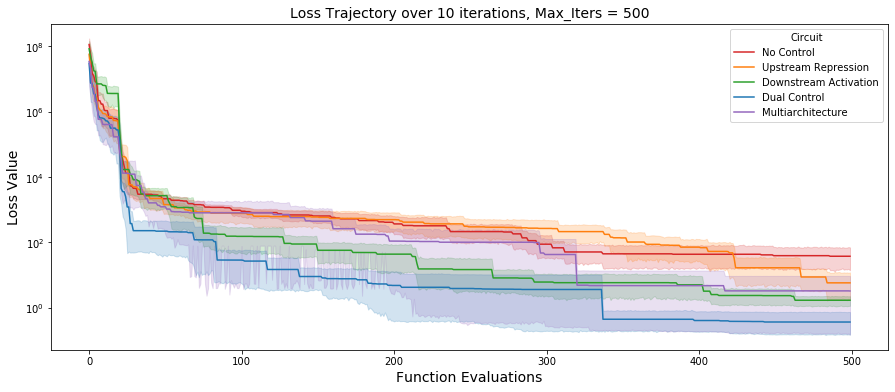

In [192]:
combined_multtries = combined_multtries.reset_index(drop=True)
fig, axs = plt.subplots(1, 1, figsize=(15, 6))
endpoint = 'Loss Trajectory over 10 iterations, Max_Iters = 500'
ax = axs
sns.lineplot(data=combined_multtries, x='iters', y='best_loss', hue='Circuit', hue_order=orders, palette=palette)
ax.set_xlabel('Function Evaluations', fontsize=14)
ax.set_ylabel('Loss Value', fontsize=14)
ax.set_title(endpoint, fontsize=14)
ax.set_yscale('log')
#fig.savefig('loss_10iters_log.png')

In [173]:
#Run with 500 iterations 10 times each

#Multiarch example
circuit_name = 'multiarch'
space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 1E-7, 10), hp.uniform('k1_da', 1E-7, 5)], [2., hp.uniform('theta2_da', 1E-7, 10), hp.uniform('k2_da', 1E-7, 5)]]),
     ([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 1E-7, 10), hp.uniform('k1_ur', 1E-7, 5)], [2., hp.uniform('theta2_ur', 1E-7, 10), hp.uniform('k2_ur', 1E-7, 5)]]),
     ([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 1E-7, 10), hp.uniform('k1_nc', 1E-7, 5)], [2., hp.uniform('theta2_nc', 1E-7, 10), hp.uniform('k2_nc', 1E-7, 5)]]),
     ([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 1E-7, 10), hp.uniform('k1_dc', 1E-7, 5)], [2., hp.uniform('theta2_dc', 1E-7, 10), hp.uniform('k2_dc', 1E-7, 5)]])
     ])
     
    
results = pd.DataFrame(columns=['circuit', 'loss', 'k1', 'k2','theta1', 'theta2'])
max_iters = 500
num_tries = 12
for n in range(num_tries):
    losses = []
    params = []
    circuits = []
    sols = []
    def objective(args):
        architecture, param_values = args
        #Integration conditions
        t = np.linspace(0, 5E5, 200) 
        y0 = np.array([0.281, 0.0605, 0., 0., 0. , 0., 0.]) #g6p, f6p, mi, ino1, miox

        extra_options = {'old_api': False, 'user_data': [architecture, param_values], 'rtol':1E-4}
        ode_solver = ode('cvode', glucaric_acid, **extra_options)
        solution = ode_solver.solve(t, y0)
        j1, j2 = solution.values.y[-1, -2:]
        j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-3)
        losses.append(loss)
        params.append(param_values)
        circuits.append(architecture)
        return loss

    best = fmin(objective, space, algo=tpe.suggest, max_evals=max_iters)
    attempt_res = pd.DataFrame({'circuit':circuits, 'loss': losses, 'k1': [params[i][0][2] for i in range(len(params))], 'k2': [params[i][1][2] for i in range(len(params))], 'theta1': [params[i][0][1] for i in range(len(params))], 'theta2': [params[i][1][1] for i in range(len(params))]})
    attempt_res['attempt'] = n
    attempt_res['best_loss'] = compute_best_loss(attempt_res)
    if losses[-1] == 0.0:
        break
    results = pd.concat([results,attempt_res])

results.to_csv(circuit_name + '_10iterations_best.csv')

 82%|████████▏ | 411/500 [00:15<00:03, 27.12trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 2202.39, mxstep steps taken before reaching tout.



100%|██████████| 500/500 [00:18<00:00, 27.28trial/s, best loss: 0.16197672613560404]


In [176]:
ma_multtries = pd.read_csv('multiarch_10iterations_best.csv')
ma_multtries = ma_multtries.loc[ma_multtries.attempt.isin([0, 1, 2, 3, 4, 5, 6, 7, 9, 10])]
ma_multtries['Circuit'] = 'Multiarchitecture'

for attempt in ma_multtries.attempt.unique():
    df = ma_multtries.loc[ma_multtries.attempt == attempt].reset_index(drop=True)
    df['iters'] = range(500)
    combined_multtries = pd.concat([combined_multtries, df])

In [177]:
grouped_combined = combined_multtries.groupby(['Circuit', 'attempt']).min().best_loss.reset_index()

gc_no_nc = combined_multtries.loc[combined_multtries.Circuit != 'No Control'].groupby(['Circuit', 'attempt']).min().best_loss.reset_index()

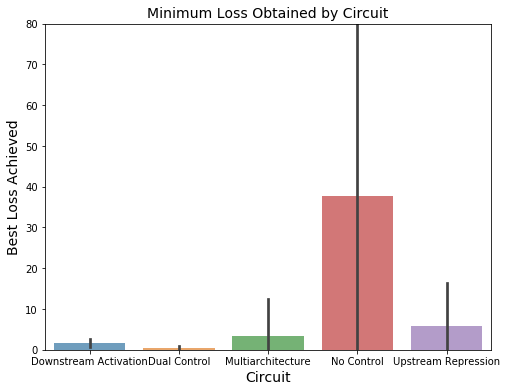

In [187]:
#num_trials_data = pd.read_csv('num_trials_data.csv')
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
endpoint = 'Minimum Loss Obtained by Circuit'
ax = axs
g = sns.barplot(
    data=grouped_combined,
    x="Circuit", y="best_loss", ci="sd", alpha=0.7)

ax.set_xlabel('Circuit', fontsize=14)
ax.set_ylabel('Best Loss Achieved', fontsize=14)
ax.set_title(endpoint, fontsize=14)
ax.set_ylim([0, 80])
fig.savefig('min_loss_bar_plot.png')


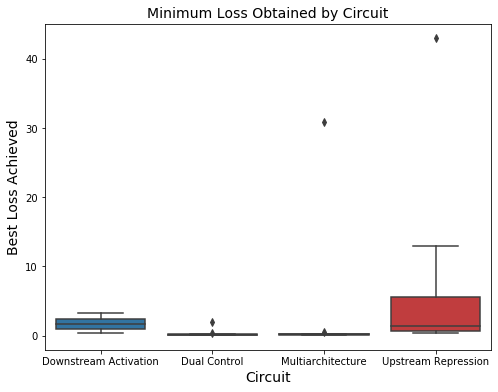

In [194]:
#num_trials_data = pd.read_csv('num_trials_data.csv')
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
endpoint = 'Minimum Loss Obtained by Circuit'
ax = axs
g = sns.boxplot(
    data=gc_no_nc,
    x="Circuit", y="best_loss") #, ci="sd", alpha=0.7)

ax.set_xlabel('Circuit', fontsize=14)
ax.set_ylabel('Best Loss Achieved', fontsize=14)
ax.set_title(endpoint, fontsize=14)
#ax.set_ylim([0, 0.07])
fig.savefig('min_loss_box_plot_multiarch_nonc.png')
